# Lab 6
## Part A: Toy Classification (Moons)
### Generate Data

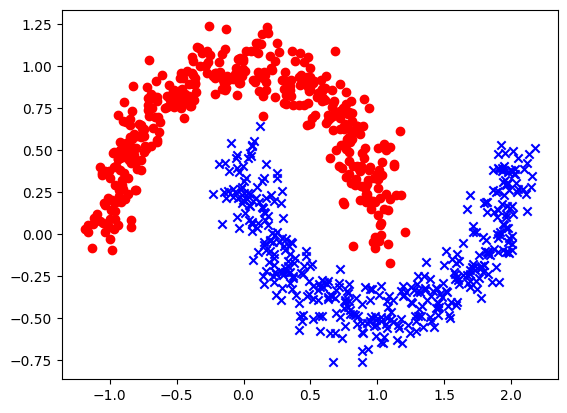

In [37]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

X, y = make_moons(n_samples=800, noise=0.1, random_state=42)

def plot_data(X, y):
  # Separate points by class
  X0 = X[y == 0]
  X1 = X[y == 1]

  # Plot
  plt.scatter(X0[:, 0], X0[:, 1], c='r', marker='o', label="Class 0")
  plt.scatter(X1[:, 0], X1[:, 1], c='b', marker='x', label="Class 1")
  plt.show()


plot_data(X, y)

### Add Noise

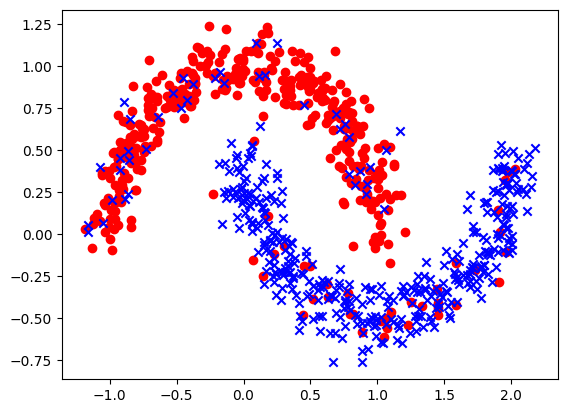

In [38]:
import numpy as np

noise_rate = 0.1
y_noisy = np.array(y)

for i in range(int(len(y) * noise_rate)):
  y_noisy[i] = 1 - y_noisy[i]

plot_data(X, y_noisy)

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y_noisy, test_size=0.3, random_state=42, stratify=y_noisy)

### MLPClassifier

In [40]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import random

accuracies = []
auc_scores = []

for i in range(5):
  print(f"Random State: {i}")

  X_train_resample, X_test_resample, y_train_resample, y_test_resample = train_test_split(X, y_noisy, test_size=0.3, random_state=i, stratify=y_noisy)

  mlp = Pipeline([
      ("scaller", StandardScaler()),
      ("mlp", MLPClassifier(max_iter=1000, solver='adam', early_stopping=True, validation_fraction=0.2, random_state=42))
  ])
  mlp.fit(X_train_resample, y_train_resample)
  y_pred = mlp.predict(X_test_resample)
  y_pred_proba = mlp.predict_proba(X_test_resample)[:,1]

  auc_scores.append(roc_auc_score(y_test_resample, y_pred_proba))
  accuracies.append(accuracy_score(y_test_resample, y_pred))

  print(f"AUC Score: {auc_scores[-1]:.4f}")
  print(f"Accuracy Score: {accuracies[-1]:.4f}\n")


  # print("--- Classification Report ---")
  # print(classification_report(y_test, y_pred))

mean_accuracy = np.mean(accuracies)
mean_auc_score = np.mean(auc_scores)

sd_accuracy = np.std(accuracies)
sd_auc_score = np.std(auc_scores)

print(f"=====\nAccuracy: {mean_accuracy:.4f}±{sd_accuracy:.4f}")
print(f"AUC Score: {mean_auc_score:.4f}±{sd_auc_score:.4f}")


Random State: 0
AUC Score: 0.8994
Accuracy Score: 0.8250

Random State: 1
AUC Score: 0.8247
Accuracy Score: 0.7458

Random State: 2
AUC Score: 0.8802
Accuracy Score: 0.8000

Random State: 3
AUC Score: 0.8702
Accuracy Score: 0.7833

Random State: 4
AUC Score: 0.8474
Accuracy Score: 0.7542

=====
Accuracy: 0.7817±0.0292
AUC Score: 0.8644±0.0260


### Different Architectures and Activations

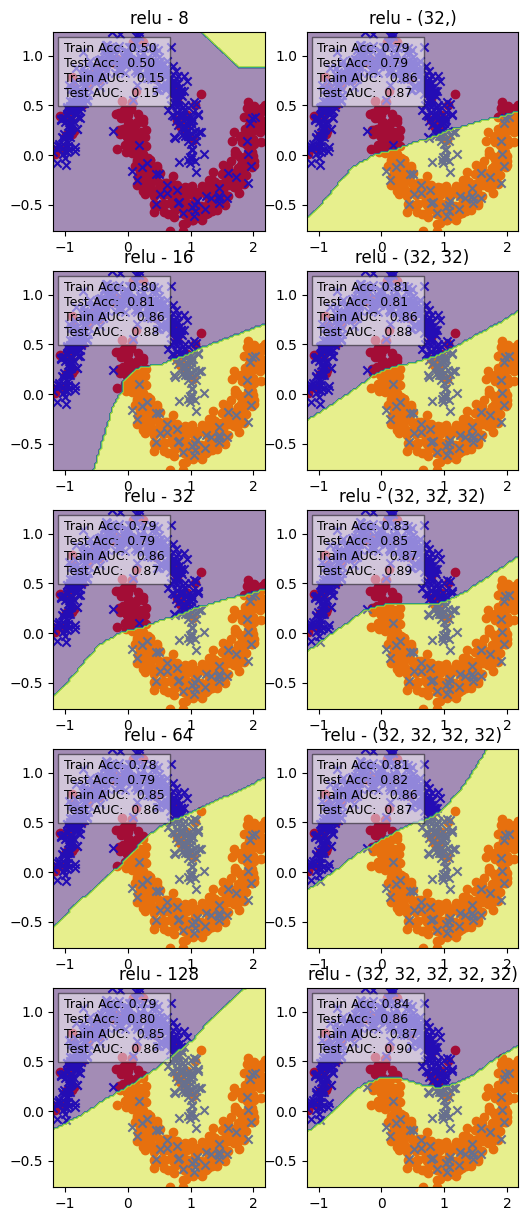

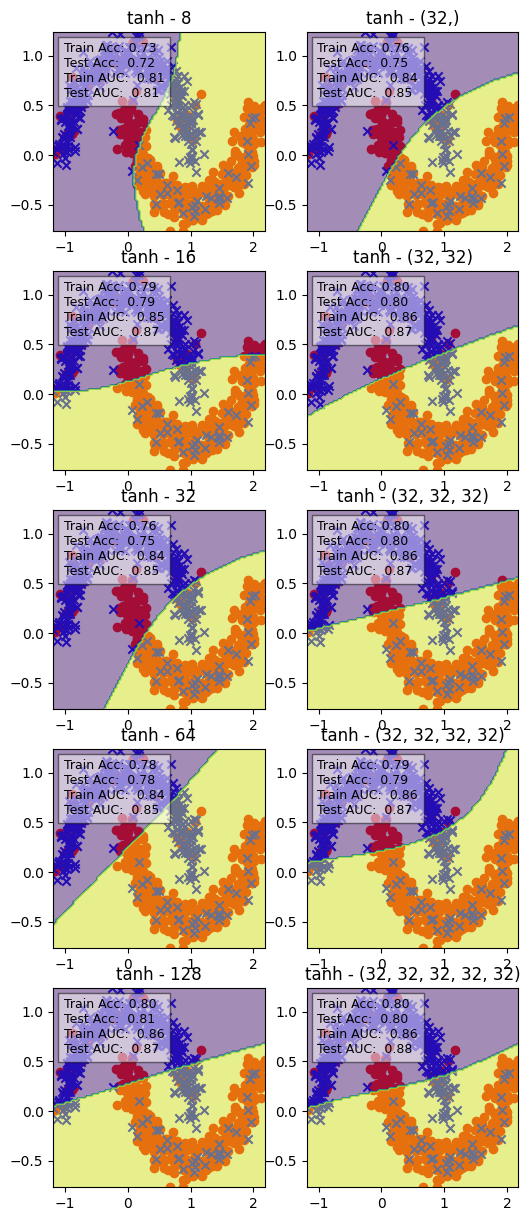

In [41]:
def plot_the_decision_boundary(plt, model, X, y):

  group_a = X[y == 1]
  group_b = X[y != 1]

  plt.scatter(group_a[:,0], group_a[:,1], c='r', marker='o', label="Class 0")
  plt.scatter(group_b[:,0], group_b[:,1], c='b', marker='x', label="Class 1")

  x_vec = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
  y_vec = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
  X_plt, Y_plt = np.meshgrid(x_vec, y_vec)

  grid_points = np.c_[X_plt.ravel(), Y_plt.ravel()]

  Z_plt = model.predict(grid_points)
  Z_plt = Z_plt.reshape(X_plt.shape)
  plt.contourf(X_plt, Y_plt, Z_plt, alpha=0.5)

architectur_size = 5

architectures = [
    [(2**(n+3)) for n in range(architectur_size)],
    [tuple(32 for _ in range(n+1)) for n in range(architectur_size)],
]

for activation in ['relu', 'tanh']:
  fig, axes = plt.subplots(nrows=architectur_size, ncols=2, figsize=(6,architectur_size*3))
  for col in [0, 1]:
    for row in range(len(architectures[col])):
      architecture = architectures[col][row]
      mlp = Pipeline([
        ("scaller", StandardScaler()),
        ("mlp", MLPClassifier(
            hidden_layer_sizes=architecture,
            activation=activation,
            max_iter=1000,
            solver='adam',
            early_stopping=True, validation_fraction=0.2,
            random_state=42))
      ])
      mlp.fit(X_train, y_train)
      y_pred_train = mlp.predict(X_train)
      y_pred_test = mlp.predict(X_test)

      accuracy_train = accuracy_score(y_train, y_pred_train)
      accuracy_test = accuracy_score(y_test, y_pred_test)

      y_pred_proba_train = mlp.predict_proba(X_train)[:,1]
      y_pred_proba_test = mlp.predict_proba(X_test)[:,1]

      auc_train = roc_auc_score(y_train, y_pred_proba_train)
      auc_test = roc_auc_score(y_test, y_pred_proba_test)

      axes[row, col].set_title(f"{activation} - {architecture}")

      stats_text = (f"Train Acc: {accuracy_train:.2f}\n"
                    f"Test Acc:  {accuracy_test:.2f}\n"
                    f"Train AUC:  {auc_train:.2f}\n"
                    f"Test AUC:  {auc_test:.2f}")

      props = dict(facecolor='white', alpha=0.5)
      axes[row, col].text(0.05, 0.95, stats_text, transform=axes[row, col].transAxes, fontsize=9,
              verticalalignment='top', bbox=props)
      plot_the_decision_boundary(axes[row, col], mlp, X, y_noisy)
    fig.show()

### Alpha Tuning

In [42]:
# Random 20% flip
random_rate = 0.2
y_noisy2 = np.array(y)

for i in range(int(len(y) * random_rate)):
  y_noisy2[i] = 1 - y_noisy2[i]

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y_noisy2, test_size=0.3, random_state=42, stratify=y_noisy2)

Alpha: 1e-05 | Validation Auc: 0.7498086734693878
Alpha: 0.0001 | Validation Auc: 0.7497448979591836
Alpha: 0.001 | Validation Auc: 0.7500637755102042
Optimal Alpha: 0.001 | Test Auc: 0.8179166666666667


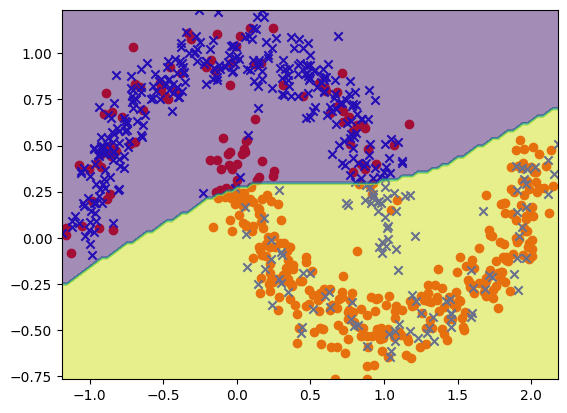

In [43]:
from sklearn.model_selection import cross_val_score

optimal_auc = 0
optimal_alpha = None

for alpha in [1e-5,1e-4,1e-3]:
  mlp = Pipeline([
      ("scaller", StandardScaler()),
      ("mlp", MLPClassifier(
      hidden_layer_sizes=(32,32,32,32),
      activation="relu",
      max_iter=1000,
      solver="adam",
      early_stopping=True, validation_fraction=0.2,
      random_state=42,
      alpha=alpha))
  ])

  cv_scores = cross_val_score(mlp, X_train2, y_train2, cv=5, scoring="roc_auc")
  auc_score = np.mean(cv_scores)

  print(f"Alpha: {alpha} | Validation Auc: {auc_score}")
  if optimal_auc < auc_score:
    optimal_auc = auc_score
    optimal_alpha = alpha

optimal_model = Pipeline([
      ("scaller", StandardScaler()),
      ("mlp", MLPClassifier(
      hidden_layer_sizes=(32,32,32,32),
      activation="relu",
      max_iter=1000,
      solver="adam",
      early_stopping=True, validation_fraction=0.2,
      random_state=42,
      alpha=optimal_alpha))
  ])

optimal_model.fit(X_train2, y_train2)

y_pred_test_proba = optimal_model.predict_proba(X_test2)[:, 1]
auc_score = roc_auc_score(y_test2, y_pred_test_proba)
print(f"======\nOptimal Alpha: {optimal_alpha} | Test Auc: {auc_score}")


plot_the_decision_boundary(plt, optimal_model, X, y_noisy2)

## Part B: Regrression (California Housing)
### Setup

In [44]:
from sklearn.datasets import fetch_california_housing

dataset = fetch_california_housing()

X, y = dataset.data, dataset.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Baseline Model

In [45]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model = Pipeline([
    ("scaller", StandardScaler()),
    ("model", MLPRegressor((128, 128), activation="relu", max_iter=1000, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Baseline Model Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE:  {mae:.4f}")
print(f"R2:   {r2:.4f}")

Baseline Model Results:
RMSE: 0.5171
MAE:  0.3491
R2:   0.7963


### Regularization & Early Stopping

In [46]:
alphas = [1e-6,1e-5,1e-4,1e-3,1e-2]

results_alpha = {}

y_train_var = np.var(y_train)

for alpha in alphas:

  mlp = MLPRegressor((128, 128),
                    activation="relu",
                    max_iter=1000,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.2,
                    n_iter_no_change=20,
                    alpha=alpha)

  model = Pipeline([
    ("scaller", StandardScaler()),
    ("model", mlp)
    ])

  model.fit(X_train, y_train)

  y_pred = model.predict(X_test)

  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)
  mae = mean_absolute_error(y_test, y_pred)
  r2 = r2_score(y_test, y_pred)

  print("----------")
  print(f"Alpha: {alpha}")
  print(f"RMSE:  {rmse:.4f}")
  print(f"MAE:   {mae:.4f}")
  print(f"R2:    {r2:.4f}")
  print("----------")

  val_r2 = np.array(mlp.validation_scores_)
  results_alpha[alpha] = {
    'train_mses': np.array(mlp.loss_curve_),
    'val_scores': np.sqrt((1 - np.minimum(val_r2, 1.0)) * y_train_var)
  }



----------
Alpha: 1e-06
RMSE:  0.5180
MAE:   0.3492
R2:    0.7956
----------
----------
Alpha: 1e-05
RMSE:  0.5159
MAE:   0.3482
R2:    0.7973
----------
----------
Alpha: 0.0001
RMSE:  0.5230
MAE:   0.3534
R2:    0.7916
----------
----------
Alpha: 0.001
RMSE:  0.5181
MAE:   0.3513
R2:    0.7955
----------
----------
Alpha: 0.01
RMSE:  0.5131
MAE:   0.3474
R2:    0.7994
----------


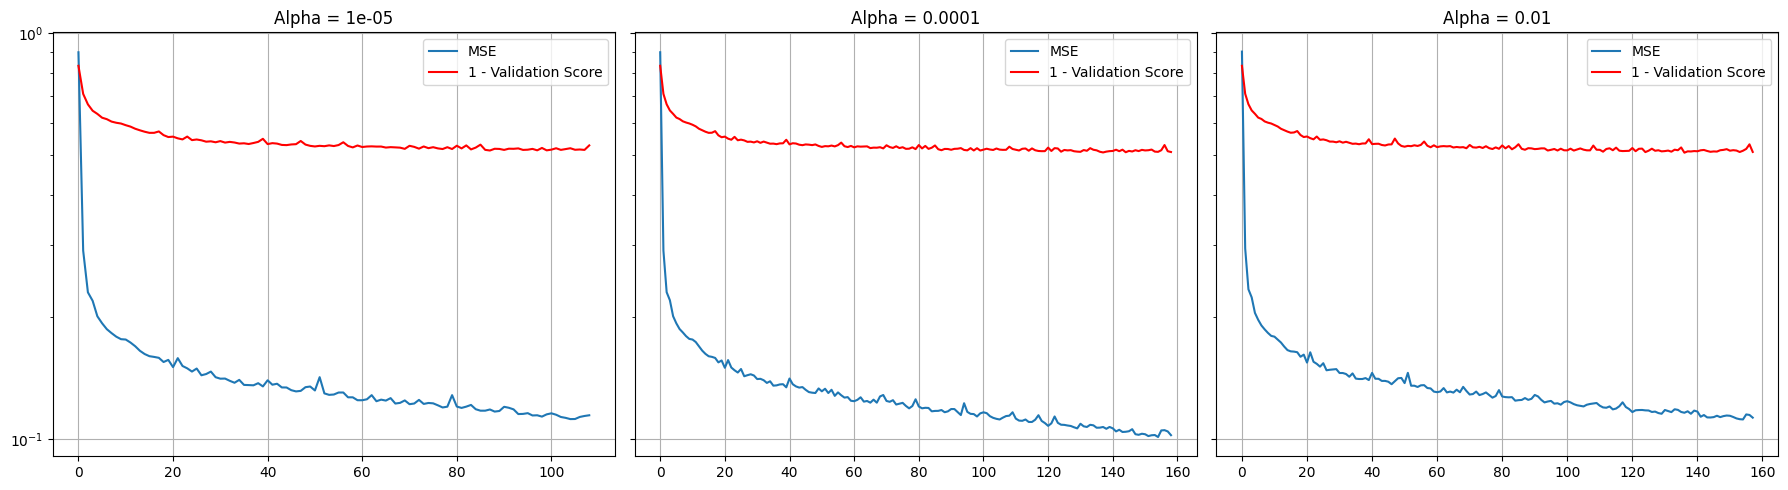

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, alpha in enumerate([1e-5,1e-4,1e-2]):
  ax1 = axes[i]
  data = results_alpha[alpha]

  line1, = ax1.plot(data['train_mses'], label='MSE')
  line2, = ax1.plot(data['val_scores'], label='1 - Validation Score', c='r')
  ax1.set_title(f"Alpha = {alpha}")

  lines = [line1, line2]
  labels = [l.get_label() for l in lines]
  ax1.legend(lines, labels, loc='upper right')
  ax1.set_yscale('log')
  ax1.grid(True,)

plt.tight_layout()
plt.show()

### Leanring-rate Schedule

In [48]:
learning_rate_modes = ['constant','adaptive']
initial_learning_rates = [1e-4,3e-4,1e-3]

results = {}

for learning_rate_mode in learning_rate_modes:
  for initial_learning_rate in initial_learning_rates:

    label = f"{learning_rate_mode}, lr={initial_learning_rate}"
    print(label)

    mlp = MLPRegressor((128, 128),
                    activation="relu",
                    max_iter=1000,
                    random_state=42,
                    early_stopping=True,
                    validation_fraction=0.2,
                    n_iter_no_change=20,
                    alpha=alpha,
                    learning_rate=learning_rate_mode,
                    learning_rate_init=initial_learning_rate,
                    solver='sgd')

    model = Pipeline([
      ("scaller", StandardScaler()),
      ("model", mlp)
      ])

    model.fit(X_train, y_train)

    results[label] = 1 - np.array(mlp.validation_scores_)


constant, lr=0.0001
constant, lr=0.0003
constant, lr=0.001
adaptive, lr=0.0001
adaptive, lr=0.0003
adaptive, lr=0.001


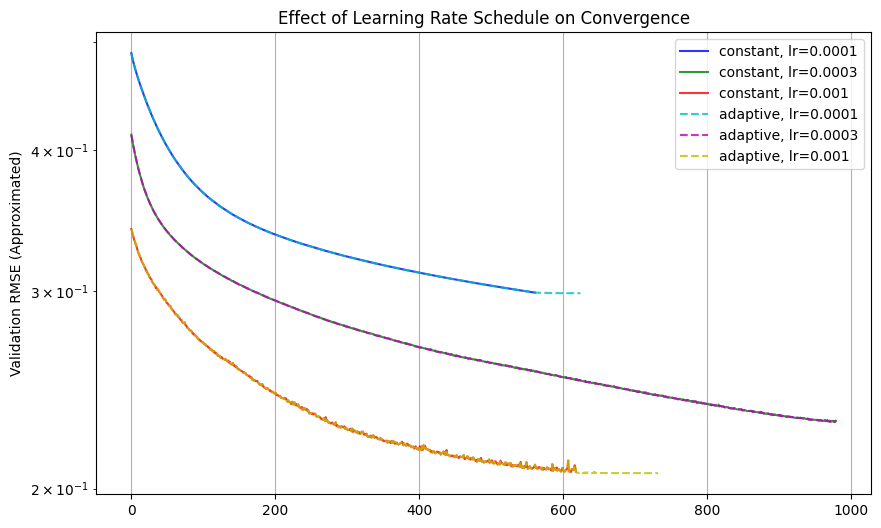

In [49]:
plt.figure(figsize=(10, 6))

colors = ['b', 'g', 'r', 'c', 'm', 'y']
styles = {'constant': '-', 'adaptive': '--'}

i = 0;
for learning_rate_mode in learning_rate_modes:
  for initial_learning_rate in initial_learning_rates:
        label = f"{learning_rate_mode}, lr={initial_learning_rate}"
        curve = results[label][20:]

        # Plot
        plt.plot(curve,
                 label=label,
                 color=colors[i],
                 linestyle=styles[learning_rate_mode],
                 alpha=0.8)
        i += 1

plt.ylabel("Validation RMSE (Approximated)")
plt.title("Effect of Learning Rate Schedule on Convergence")
plt.legend()
plt.grid(True)
plt.yscale('log')
plt.show()

### Hyperparameter optimisation (RandomizedSearchCV).

In [50]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import loguniform, uniform

mlp = MLPRegressor(
                  activation="relu",
                  max_iter=1000,
                  random_state=42,
                  early_stopping=True)

model = Pipeline([
  ("scaller", StandardScaler()),
  ("model", mlp)
  ])

param_distributions = {
    'model__hidden_layer_sizes': [
        (64, 64), (128, 128), (256, 256), (128, 64),
    ],
    'model__alpha': loguniform(1e-6, 1e-2),
    'model__learning_rate_init': loguniform(1e-4, 1e-2),
    'model__solver': ['adam', 'sgd'],
    'model__batch_size': [32, 64, 128],
    'model__momentum': uniform(0.6, 0.35)
}

n_iter = 10

rscv = RandomizedSearchCV(
    model,
    param_distributions=param_distributions,
    n_iter=n_iter,
    cv=5,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42
)

rscv.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaller', StandardScaler()),
                                             ('model',
                                              MLPRegressor(early_stopping=True,
                                                           max_iter=1000,
                                                           random_state=42))]),
                   param_distributions={'model__alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f54f910>,
                                        'model__batch_size': [32, 64, 128],
                                        'model__hidden_layer_sizes': [(64, 64),
                                                                      (128,
                                                                       128),
                                                                      (256,
                                                                       256),
                                                                      (128,
                                                                       64)],
                                        'model__learning_rate_init': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x14f4dbb50>,
                                        'model__momentum': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x168086130>,
                                        'model__solver': ['adam', 'sgd']},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [51]:
import pandas as pd

print(f"Parameters: {rscv.best_params_}")
print(f"Score: {rscv.best_score_}")

best_model = rscv.best_estimator_
y_pred = best_model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test RMSE: {test_rmse}")

Parameters: {'model__alpha': np.float64(3.1489116479568635e-05), 'model__batch_size': 32, 'model__hidden_layer_sizes': (256, 256), 'model__learning_rate_init': np.float64(0.0029106359131330704), 'model__momentum': np.float64(0.8095304694689628), 'model__solver': 'adam'}
Score: -0.5290573127427554
Test RMSE: 0.5088054783886947
